In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
from PIL import Image
import numpy as np

# Define the root directory where your data is stored
root_dir = '/kaggle/input/brg-dataset-task3/BrG_Dataset_Download' 

# Define the subdirectories for 'glaucoma' and 'normal' classes
glaucoma_dir = os.path.join(root_dir, 'glaucoma')
normal_dir = os.path.join(root_dir, 'normal')

# Initialize lists to store image data and labels
images = []
labels = []  # 0 for 'normal' and 1 for 'glaucoma'

# Load 'glaucoma' images
for folder in os.listdir(glaucoma_dir):
    folder_path = os.path.join(glaucoma_dir, folder)
    if os.path.isdir(folder_path):
        label = 1  # Glaucoma
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):  # Assuming images are in JPG format
                image_path = os.path.join(folder_path, filename)
                image = Image.open(image_path)
                # Perform any necessary preprocessing on the image (e.g., resizing, normalization)
                # image = preprocess_image(image)
                images.append(np.array(image))
                labels.append(label)

# Load 'normal' images
for filename in os.listdir(normal_dir):
    if filename.endswith('.png'):  # Assuming images are in JPG format
        image_path = os.path.join(normal_dir, filename)
        image = Image.open(image_path)
        # Perform any necessary preprocessing on the image (e.g., resizing, normalization)
        # image = preprocess_image(image)
        images.append(np.array(image))
        labels.append(0)  # Normal

# Convert lists to NumPy arrays for further processing
images = np.array(images)
labels = np.array(labels)

# Optionally, split your data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)



/tmp/ipykernel_64/4075037699.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [35]:
data_dir = '/kaggle/input/brg-dataset-task3/BrG_Dataset_Download'
# Define data preprocessing parameters
batch_size = 64
image_size = (224, 224)

In [36]:
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    validation_split=0.2,      # Split data into training and validation sets
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift the width of images
    height_shift_range=0.2,    # Randomly shift the height of images
    horizontal_flip=True       # Randomly flip images horizontally
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121  # Import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os

# Create and compile the DenseNet-121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,  
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[es],
    verbose=2
)


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/50
75/75 - 234s - loss: 0.5805 - accuracy: 0.6706 - val_loss: 0.4190 - val_accuracy: 0.8194 - 234s/epoch - 3s/step
Epoch 2/50
75/75 - 91s - loss: 0.4978 - accuracy: 0.7215 - val_loss: 0.4183 - val_accuracy: 0.8177 - 91s/epoch - 1s/step
Epoch 3/50
75/75 - 111s - loss: 0.4914 - accuracy: 0.7248 - val_loss: 0.3883 - val_accuracy: 0.8264 - 111s/epoch - 1s/step
Epoch 4/50
75/75 - 91s - loss: 0.4956 - accuracy: 0.7194 - val_loss: 0.4526 - val_accuracy: 0.7908 - 91s/epoch - 1s/step
Epoch 5/50
75/75 - 90s - loss: 0.4788 - accuracy: 0.7373 - val_loss: 0.4485 - val_accuracy: 0.8003 - 90s/epoch - 1s/step
Epoch 6/50
75/75 - 90s - loss: 0.4752 - accuracy: 0.7304 - val_loss: 0.3867 - val_accuracy: 0.8316 - 90s/epoch - 1s/step
Epoch 7/50
75/75 - 112s - loss: 0.4700 - accuracy: 0.7406 - val_loss: 0.3661 - val_accuracy: 0.8255 - 112s/epoch - 1s/step
Epoch 8/50
75/75 - 92s - loss: 0.4605 - accuracy: 0.7433 - val_loss: 0.3589 - val_

In [51]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

94/94 - 39s - loss: 0.4224 - accuracy: 0.7643 - 39s/epoch - 418ms/step
Test Accuracy: 0.7643
Test Loss: 0.4224


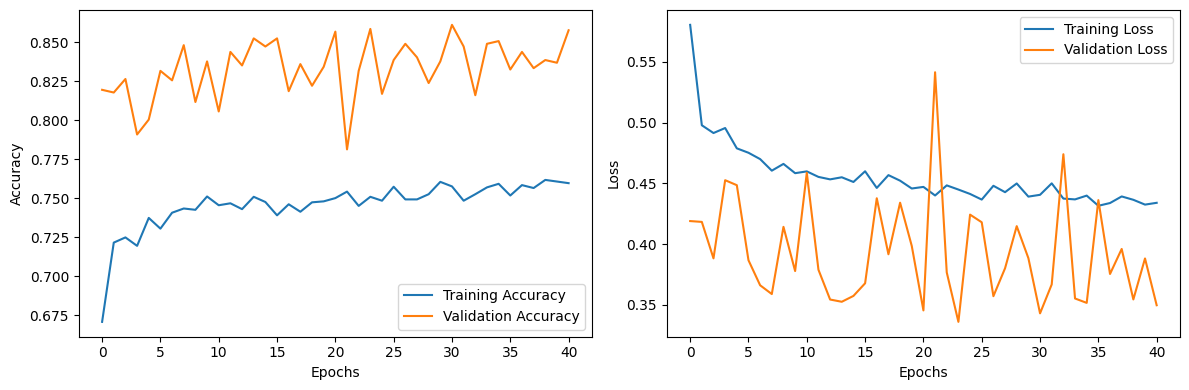

In [52]:
import matplotlib.pyplot as plt


# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

19/19 [==============================] - 23s 1s/step


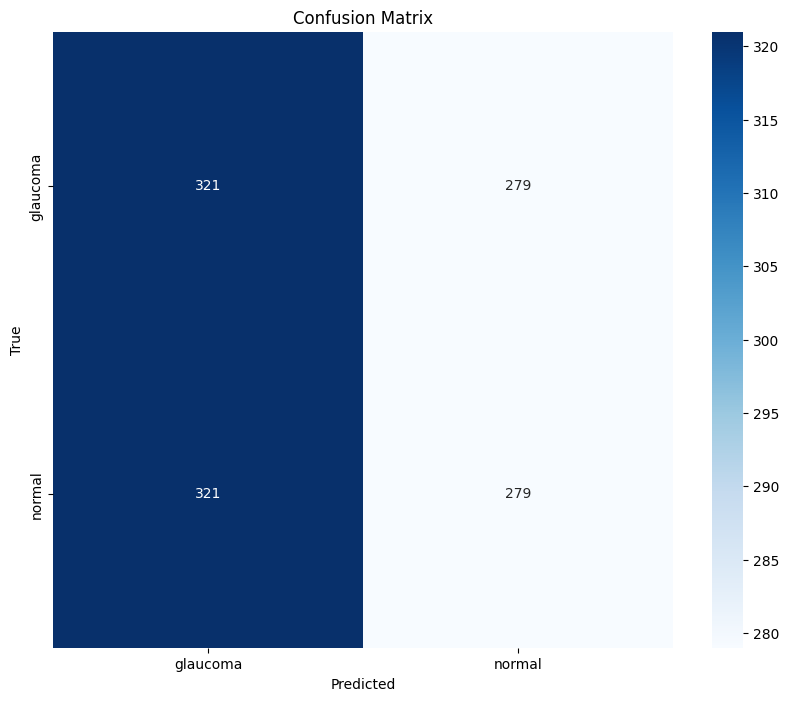

              precision    recall  f1-score   support

    glaucoma       0.50      0.54      0.52       600
      normal       0.50      0.47      0.48       600

    accuracy                           0.50      1200
   macro avg       0.50      0.50      0.50      1200
weighted avg       0.50      0.50      0.50      1200



In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have trained your model and have it in a variable called 'model'
# Make predictions using the validation_generator
y_pred = model.predict(validation_generator)

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = validation_generator.classes

# Get class labels from the generator
class_labels = list(validation_generator.class_indices.keys())

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report for additional metrics
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print(report)

In [54]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have trained your model and have it in a variable called 'model'
# Make predictions using the validation_generator
y_pred = model.predict(validation_generator)

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = validation_generator.classes

# Get class labels from the generator
class_labels = list(validation_generator.class_indices.keys())

# Calculate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

# Print the classification report
print(report)

19/19 [==============================] - 21s 1s/step
              precision    recall  f1-score   support

    glaucoma       0.52      0.56      0.54       600
      normal       0.52      0.47      0.50       600

    accuracy                           0.52      1200
   macro avg       0.52      0.52      0.52      1200
weighted avg       0.52      0.52      0.52      1200



19/19 [==============================] - 21s 1s/step


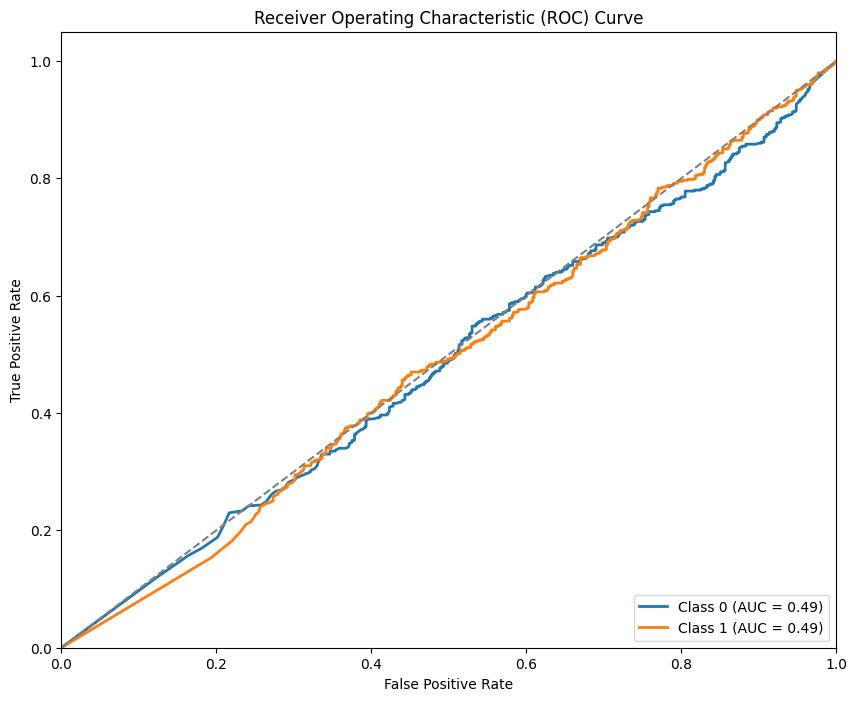

In [55]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have trained your model and have it in a variable called 'model'
# Make predictions using the validation_generator
y_pred = model.predict(validation_generator)

# Convert one-hot encoded predictions and true labels to class labels
y_true_classes = validation_generator.classes

# Get the number of classes
num_classes = len(validation_generator.class_indices)

# Initialize dictionaries to store ROC curve data for each class
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC curve and ROC AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_classes == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [58]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

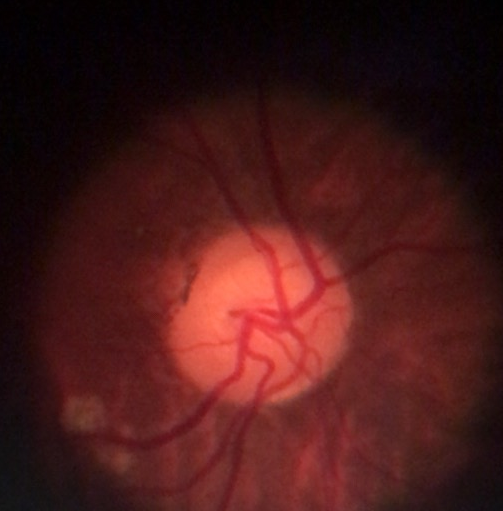

In [69]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = "/kaggle/input/brg-dataset-task3/BrG_Dataset_Download/glaucoma/right eye - glaucoma/imGOD (103).png"

display(Image(img_path))

In [70]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 749ms/step
Predicted: [('n01910747', 'jellyfish', 9.91)]


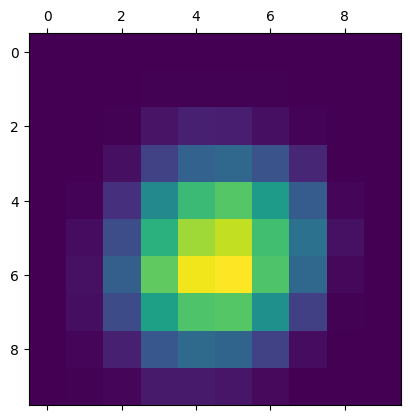

In [71]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

/tmp/ipykernel_64/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


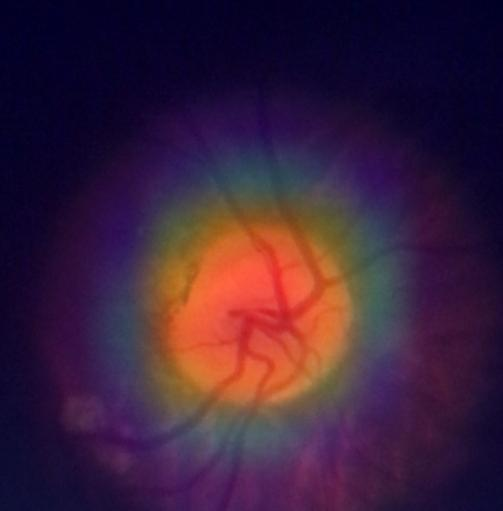

In [72]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

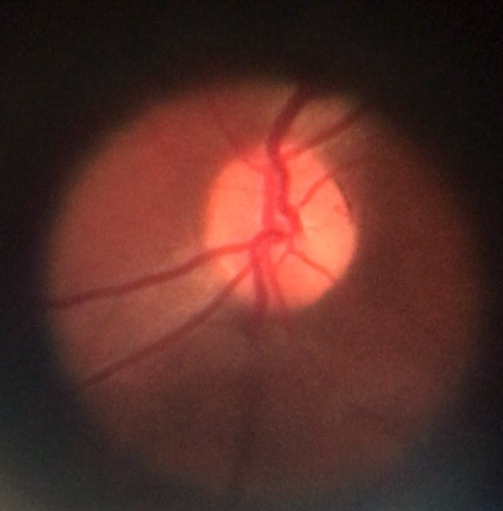

1/1 [==============================] - 0s 24ms/step
Predicted: [('n01910747', 'jellyfish', 7.215), ('n03590841', "jack-o'-lantern", 7.004)]


In [73]:
img_path = "/kaggle/input/brg-dataset-task3/BrG_Dataset_Download/normal/left eye  - normal/imNOE (105).png"

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

/tmp/ipykernel_64/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


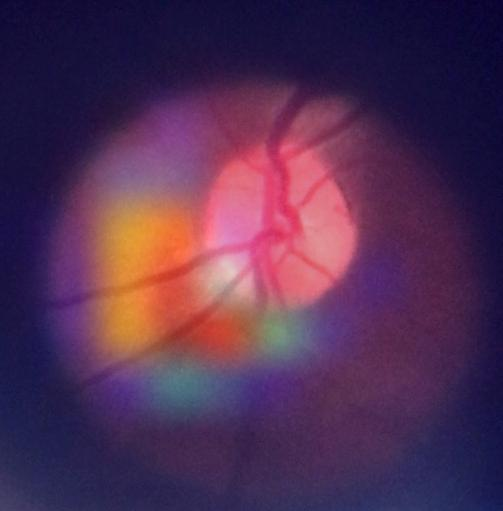

In [74]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

/tmp/ipykernel_64/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


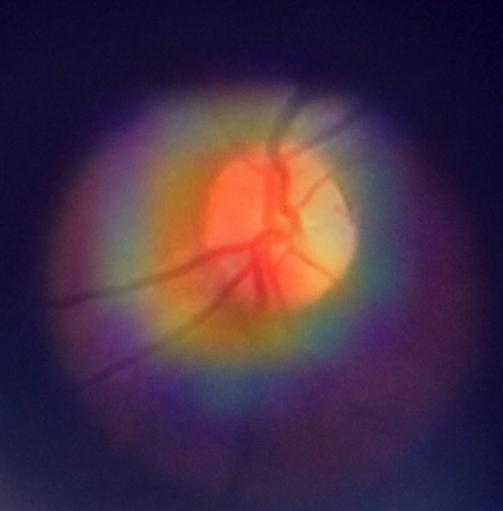

In [75]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)

In [76]:
# Optionally, save the trained model
model.save('densenet121_model.h5')

# **MixUp agumentation**

In [107]:
from skimage.transform import resize

def mixup_data(X, y, alpha=0.2):
    X_mix = []
    y_mix = []

    for i in range(len(X_train)):
        x1, x2 = X_train[i], X_train[np.random.choice(len(X_train))]
        y1, y2 = y_train[i], y_train[np.random.choice(len(y_train))]

        # Resize both images to a common shape (e.g., 224x224)
        common_shape = (224, 224)
        x1 = resize(x1, common_shape)
        x2 = resize(x2, common_shape)

        beta = np.random.beta(alpha, alpha)
        X_mix.append(beta * x1 + (1 - beta) * x2)
        y_mix.append(beta * y1 + (1 - beta) * y2)

    return np.array(X_mix), np.array(y_mix)

# Apply MixUp to your training data
X_train, y_train = mixup_data(X_train, y_train)


In [108]:
# Create and compile the DenseNet-121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [109]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

In [111]:
from tensorflow.keras.utils import to_categorical

# Assuming you have 2 classes (e.g., normal and glaucoma)
num_classes = 2

# One-hot encode your labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [1]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ImportError: cannot import name 'experimental' from 'tensorflow.keras.mixed_precision' (/opt/conda/lib/python3.10/site-packages/keras/api/_v2/keras/mixed_precision/__init__.py)

In [2]:
# Define a custom training step function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = compute_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_accuracy.update_state(labels, predictions)

    return loss


# Training loop
for epoch in range(20):
    for batch in train_generator:
        inputs, labels = batch
        loss = train_step(inputs, labels)

    template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}'
    print(template.format(epoch + 1, loss, train_accuracy.result()))
    train_accuracy.reset_states()


NameError: name 'train_generator' is not defined

In [3]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=2
)


NameError: name 'model' is not defined

# **Kfold**

In [121]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Define the number of folds
n_splits = 5
kf = KFold(n_splits=n_splits)

# Create lists to store model performance metrics for each fold
accuracy_scores = []
loss_scores = []
roc_auc_scores = []
classification_reports = []
gradcam_images = []

# Define the GradCAM settings
last_conv_layer_name = "block14_sepconv2_act"
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# Loop over the folds
for fold, (train_index, test_index) in enumerate(kf.split(images)):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Create and compile the model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[es], verbose=2)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    accuracy_scores.append(test_accuracy)
    loss_scores.append(test_loss)

    # ROC curve and AUC
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

    # Classification report
    y_pred_classes = np.argmax(y_pred, axis=1)
    class_labels = ['normal', 'glaucoma']
    report = classification_report(np.argmax(y_test, axis=1), y_pred_classes, target_names=class_labels)
    classification_reports.append(report)

    # GradCAM visualization
    for i in range(5):  # Visualize GradCAM for the first 5 images
        img_path = f"Path to the image in X_test"
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        cam_path = f"gradcam_fold_{fold}_image_{i}.jpg"
        save_and_display_gradcam(img_path, heatmap, cam_path)
        gradcam_images.append(cam_path)

# Print the average performance metrics across all folds
print(f"Average Test Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Test Loss: {np.mean(loss_scores):.4f}")
print(f"Average ROC AUC: {np.mean(roc_auc_scores):.4f}")

# Print classification reports for each fold
for fold, report in enumerate(classification_reports):
    print(f"Classification Report for Fold {fold + 1}:\n{report}")

# Display GradCAM images
for img_path in gradcam_images:
    display(Image(img_path))


IndexError: index 200 is out of bounds for axis 0 with size 64

# **MobileNetV2**

In [77]:
from tensorflow.keras.applications import EfficientNetB0, InceptionV3, MobileNetV2

In [81]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='min', verbose=1)

In [82]:
# Define and compile the MobileNetV2 model
mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = xception_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='sigmoid')(x)

model_mobilenetv2 = Model(inputs=mobilenetv2_model.input, outputs=predictions)

model_mobilenetv2.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'") at layer "block1_conv1". The following previous layers were accessed without issue: []

In [14]:
# Train the MobileNetV2 model
history_mobilenetv2 = model_mobilenetv2.fit(train_generator,
                                            validation_data=validation_generator, 
                                            epochs=20, 
                                            callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 3.0616 - accuracy: 0.6006
Epoch 1: val_loss improved from inf to 9.04839, saving model to best_model.h5
38/38 [==============================] - 150s 3s/step - loss: 3.0616 - accuracy: 0.6006 - val_loss: 9.0484 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.5509 - accuracy: 0.6825
Epoch 2: val_loss did not improve from 9.04839
38/38 [==============================] - 97s 3s/step - loss: 0.5509 - accuracy: 0.6825 - val_loss: 9.6612 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.7177
Epoch 3: val_loss did not improve from 9.04839
38/38 [==============================] - 96s 3s/step - loss: 0.5014 - accuracy: 0.7177 - val_loss: 20.3393 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.5060 - accuracy: 0.7167
Epoch 4: ReduceLROnPlate

In [15]:
mobilenetv2_test_loss, mobilenetv2_test_acc = model_mobilenetv2.evaluate(test_generator)
print("MobileNetV2 Test Loss: ", mobilenetv2_test_loss)
print("MobileNetV2 Test Accuracy: ", mobilenetv2_test_acc)

47/47 [==============================] - 36s 758ms/step - loss: 8.7350 - accuracy: 0.5000
MobileNetV2 Test Loss:  8.734980583190918
MobileNetV2 Test Accuracy:  0.5


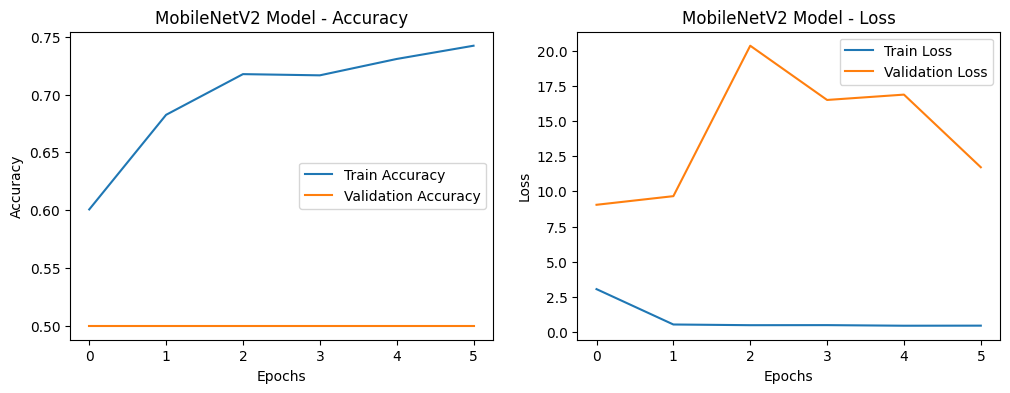

In [16]:
# Plot accuracy and loss for MobileNetV2
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Model - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2.history['loss'], label='Train Loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNetV2 Model - Loss')
plt.legend()
plt.show()

# **InceptionV3 model**

In [17]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

In [18]:
# Define and compile the InceptionV3 model
inceptionv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = inceptionv3_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_inceptionv3 = Model(inputs=inceptionv3_model.input, outputs=predictions)

model_inceptionv3.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [19]:
# Train the InceptionV3 model
history_inceptionv3 = model_inceptionv3.fit(train_generator,
                                            validation_data=validation_generator, 
                                            epochs=20, 
                                            callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 2.1069 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.71473, saving model to best_model.h5
38/38 [==============================] - 162s 3s/step - loss: 2.1069 - accuracy: 0.5000 - val_loss: 0.7147 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.71473 to 0.69710, saving model to best_model.h5
38/38 [==============================] - 105s 3s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6971 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 3: val_loss improved from 0.69710 to 0.69378, saving model to best_model.h5
38/38 [==============================] - 104s 3s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
38/38 [=============================

In [20]:
inceptionv3_test_loss, inceptionv3_test_acc = model_inceptionv3.evaluate(test_generator)
print("InceptionV3 Test Loss: ", inceptionv3_test_loss)
print("InceptionV3 Test Accuracy: ", inceptionv3_test_acc)

47/47 [==============================] - 40s 852ms/step - loss: 0.6931 - accuracy: 0.5000
InceptionV3 Test Loss:  0.6931475400924683
InceptionV3 Test Accuracy:  0.5


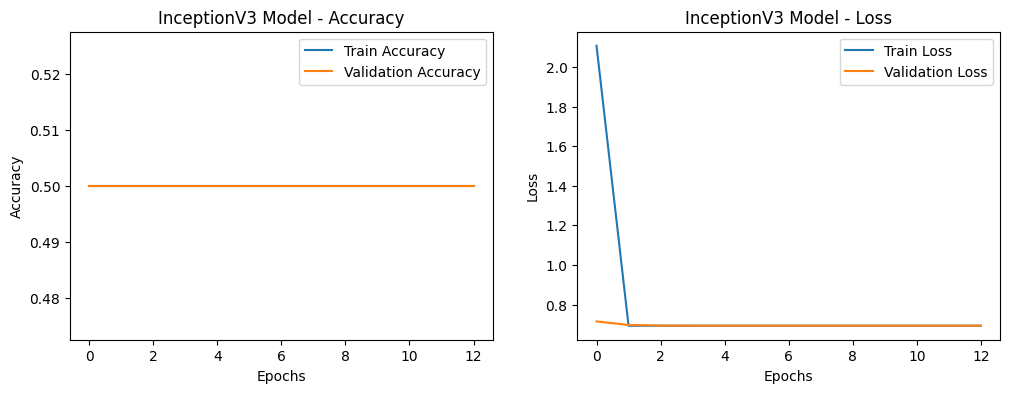

In [21]:
# Plot accuracy and loss for InceptionV3
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_inceptionv3.history['accuracy'], label='Train Accuracy')
plt.plot(history_inceptionv3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('InceptionV3 Model - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_inceptionv3.history['loss'], label='Train Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('InceptionV3 Model - Loss')
plt.legend()
plt.show()

# **EfficientNetB0 model**

In [22]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

In [23]:
# Define and compile the EfficientNetB0 model
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = efficientnet_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_efficientnet = Model(inputs=efficientnet_model.input, outputs=predictions)

model_efficientnet.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [37]:
# Train the EfficientNetB0 model
history_efficientnet = model_efficientnet.fit(train_generator,
                                              validation_data=validation_generator,
                                              epochs=20,
                                              callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/20
75/75 [==============================] - ETA: 0s - loss: 0.9852 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69316, saving model to best_model.h5
75/75 [==============================] - 113s 2s/step - loss: 0.9852 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.69316 to 0.69315, saving model to best_model.h5
75/75 [==============================] - 107s 1s/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 3: val_loss improved from 0.69315 to 0.69315, saving model to best_model.h5
75/75 [==============================] - 109s 1s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
75/75 [=============================

In [38]:
efficientnet_test_loss, efficientnet_test_acc = model_efficientnet.evaluate(test_generator)
print("EfficientNetB0 Test Loss: ", efficientnet_test_loss)
print("EfficientNetB0 Test Accuracy: ", efficientnet_test_acc)

94/94 [==============================] - 38s 406ms/step - loss: 0.6931 - accuracy: 0.5000
EfficientNetB0 Test Loss:  0.6931466460227966
EfficientNetB0 Test Accuracy:  0.5


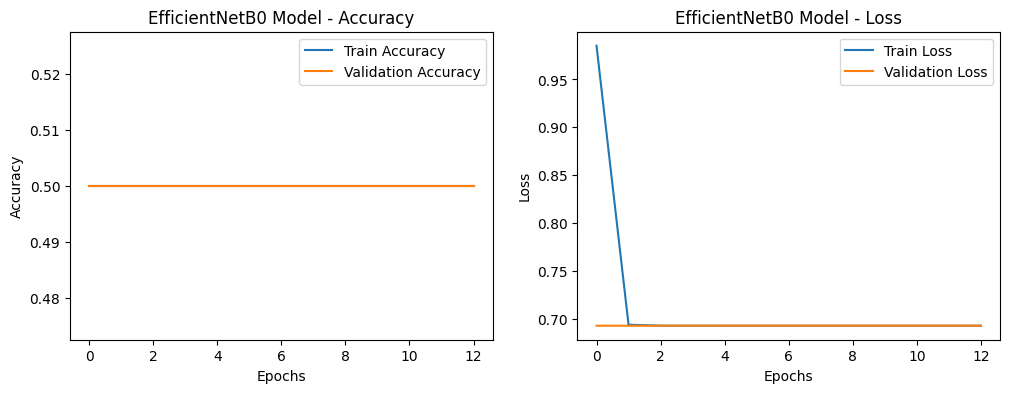

In [39]:
# Plot accuracy and loss for EfficientNetB0
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('EfficientNetB0 Model - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EfficientNetB0 Model - Loss')
plt.legend()
plt.show()

# **Xeption Model**

In [40]:
from tensorflow.keras.applications import Xception

In [41]:
# Define and compile the Xception model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = xception_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_xception = Model(inputs=xception_model.input, outputs=predictions)

model_xception.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='min', verbose=1)

In [45]:
# Train the Xception model
history_xception = model_xception.fit(train_generator, 
                                      validation_data=validation_generator,
                                      epochs=20, 
                                      callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/20
75/75 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.5000
Epoch 1: val_accuracy improved from inf to 0.50000, saving model to best_model.h5
75/75 [==============================] - 147s 1s/step - loss: 0.6949 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5000
Epoch 2: val_accuracy did not improve from 0.50000
75/75 [==============================] - 100s 1s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/20
75/75 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.50000
75/75 [==============================] - 101s 1s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/20
75/75 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5000

In [46]:
xception_test_loss, xception_test_acc = model_xception.evaluate(test_generator)
print("Xception Test Loss: ", xception_test_loss)
print("Xception Test Accuracy: ", xception_test_acc)

94/94 [==============================] - 33s 353ms/step - loss: 0.6934 - accuracy: 0.5000
Xception Test Loss:  0.693359375
Xception Test Accuracy:  0.5


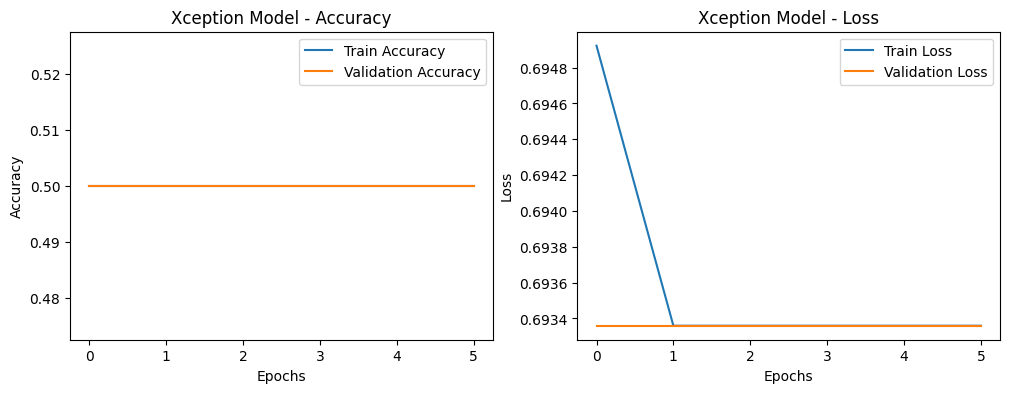

In [47]:
# Plot accuracy and loss for Xception
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_xception.history['accuracy'], label='Train Accuracy')
plt.plot(history_xception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Xception Model - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_xception.history['loss'], label='Train Loss')
plt.plot(history_xception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Xception Model - Loss')
plt.legend()
plt.show()

In [48]:
# Evaluate models and generate reports
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_and_report(model, test_generator, model_name):
    y_pred = model.predict(test_generator)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_binary)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Glaucoma'], yticklabels=['Normal', 'Glaucoma'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Classification Report
    print(f'Classification Report - {model_name}:\n', classification_report(y_test, y_pred_binary))

evaluate_and_report(model_mobilenetv2, test_generator, 'MobileNetV2')
evaluate_and_report(model_inceptionv3, test_generator, 'InceptionV3')
evaluate_and_report(model_efficientnet, test_generator, 'EfficientNetB0')
evaluate_and_report(model_xception, test_generator, 'Xception')

94/94 [==============================] - 37s 377ms/step


ValueError: Found input variables with inconsistent numbers of samples: [200, 6000]

# **Kfold**

In [83]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store the model performances
mobilenetv2_cv_scores = []
inceptionv3_cv_scores = []
efficientnet_cv_scores = []
xception_cv_scores = []

# Define the cross-validation split using StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Iterate over the folds
for train_index, val_index in skf.split(images, labels):
    # Split the data into training and validation sets for this fold
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Create and compile the models for each fold
    model_mobilenetv2 = create_mobilenetv2_model()  # Define your MobileNetV2 model creation function
    model_inceptionv3 = create_inceptionv3_model()  # Define your InceptionV3 model creation function
    model_efficientnet = create_efficientnet_model()  # Define your EfficientNetB0 model creation function
    model_xception = create_xception_model()  # Define your Xception model creation function

    # Train the models on the current fold
    history_mobilenetv2 = model_mobilenetv2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=0)
    history_inceptionv3 = model_inceptionv3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=0)
    history_efficientnet = model_efficientnet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=0)
    history_xception = model_xception.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=0)

    # Evaluate the models on the validation set of the current fold
    mobilenetv2_val_loss, mobilenetv2_val_acc = model_mobilenetv2.evaluate(X_val, y_val, verbose=0)
    inceptionv3_val_loss, inceptionv3_val_acc = model_inceptionv3.evaluate(X_val, y_val, verbose=0)
    efficientnet_val_loss, efficientnet_val_acc = model_efficientnet.evaluate(X_val, y_val, verbose=0)
    xception_val_loss, xception_val_acc = model_xception.evaluate(X_val, y_val, verbose=0)

    # Append the validation accuracy scores to the lists
    mobilenetv2_cv_scores.append(mobilenetv2_val_acc)
    inceptionv3_cv_scores.append(inceptionv3_val_acc)
    efficientnet_cv_scores.append(efficientnet_val_acc)
    xception_cv_scores.append(xception_val_acc)

# Calculate and print the mean and standard deviation of the cross-validation scores
print("MobileNetV2 Cross-Validation Mean Accuracy:", np.mean(mobilenetv2_cv_scores))
print("MobileNetV2 Cross-Validation Std. Deviation:", np.std(mobilenetv2_cv_scores))

print("InceptionV3 Cross-Validation Mean Accuracy:", np.mean(inceptionv3_cv_scores))
print("InceptionV3 Cross-Validation Std. Deviation:", np.std(inceptionv3_cv_scores))

print("EfficientNetB0 Cross-Validation Mean Accuracy:", np.mean(efficientnet_cv_scores))
print("EfficientNetB0 Cross-Validation Std. Deviation:", np.std(efficientnet_cv_scores))

print("Xception Cross-Validation Mean Accuracy:", np.mean(xception_cv_scores))
print("Xception Cross-Validation Std. Deviation:", np.std(xception_cv_scores))


# Plot accuracy and loss for Xception
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_xception.history['accuracy'], label='Train Accuracy')
plt.plot(history_xception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Xception Model - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_xception.history['loss'], label='Train Loss')
plt.plot(history_xception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Xception Model - Loss')
plt.legend()
plt.show()


NameError: name 'create_mobilenetv2_model' is not defined